In [1]:
import time

from collections import OrderedDict
from pathlib import Path

import torch
from lib.structures.field_list import collect

from lib import utils, logger, config, modeling, solver, data

import os
import sys

%load_ext autoreload
%autoreload 2

In [2]:
# Reading aux views
views_list = open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/viewslist_0009.txt', 'r')
views_names = []
for view_name in views_list.readlines():
    views_names.append(view_name.replace('\n',''))
print(views_names)

['0017', '0025', '0029']


In [3]:
config.merge_from_file('configs/front3d_train_3d_test.yaml')
model = modeling.PanopticReconstruction()
device = torch.device(config.MODEL.DEVICE)
model.to(device, non_blocking=True)
model.log_model_info()
model.fix_weights()

# Setup optimizer, scheduler, checkpointer
optimizer = torch.optim.Adam(model.parameters(), config.SOLVER.BASE_LR,
                                          betas=(config.SOLVER.BETA_1, config.SOLVER.BETA_2),
                                          weight_decay=config.SOLVER.WEIGHT_DECAY)
scheduler = solver.WarmupMultiStepLR(optimizer, config.SOLVER.STEPS, config.SOLVER.GAMMA,
                                                  warmup_factor=1,
                                                  warmup_iters=0,
                                                  warmup_method="linear")

-----------------------------------------
unet_output_channels 16
unet_fetures 16
#params discriminator 173808


In [4]:
# For Inference
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_64 = 1 # 10000
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_128 = 2 # 25000
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_256 = 3 #5000
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_RGB = 4 #5000  #TO DO: Implement. Right now it is unused

In [5]:
model_dict = model.state_dict()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Trainable Parameters: {}".format(pytorch_total_params))

output_path = Path('out')
checkpointer = utils.DetectronCheckpointer(model, optimizer, scheduler, output_path)

# Load the checkpoint
checkpoint_data = checkpointer.load()

checkpoint_arguments = {}
checkpoint_arguments["iteration"] = 0

if config.SOLVER.LOAD_SCHEDULER:
    checkpoint_arguments.update(checkpoint_data)

if config.MODEL.PRETRAIN2D:
    pretrain_2d = torch.load(config.MODEL.PRETRAIN2D)
    model.load_state_dict(pretrain_2d["model"])

# Dataloader
dataloader = data.setup_dataloader(config.DATASETS.TRAIN)

Number of Trainable Parameters: 10940199
Number of Trainable Parameters: 10940199


In [6]:
iteration = 0
iteration_end = time.time()
model.switch_training()

for idx, (image_ids, targets) in enumerate(dataloader):
    assert targets is not None, "error during data loading"
    data_time = time.time() - iteration_end
    # Get input images
    images = collect(targets, "color")

    # Pass through model
    # try:
    losses, results = model(images, targets)
    # except Exception as e:
    #     print(e, "skipping", image_ids[0])
    #     del targets, images
    #     continue

    # Accumulate total loss
    total_loss: torch.Tensor = 0.0
    log_meters = OrderedDict()
    rgb_loss = 0.0
    for loss_group in losses.values():
        for loss_name, loss in loss_group.items():
            if(loss_name == "rgb_total_loss"):
                # print("loss_name: {}, loss: {}".format(loss_name, loss))
                rgb_loss = loss
            if torch.is_tensor(loss) and not torch.isnan(loss) and not torch.isinf(loss):
                total_loss += loss
                log_meters[loss_name] = loss.item()

    # Loss backpropagation, optimizer & scheduler step
    optimizer.zero_grad()

    if torch.is_tensor(total_loss):
        # total_loss.backward()
        # optimizer.step()
        # scheduler.step()
        log_meters["total"] = total_loss.item()
    else:
        log_meters["total"] = total_loss

    # Minkowski Engine recommendation
    torch.cuda.empty_cache()

    # Save checkpoint
    # if iteration % config.SOLVER.CHECKPOINT_PERIOD == 0:
    #     checkpointer.save(f"model_{iteration:07d}", **checkpoint_arguments)

    last_training_stage = model.set_current_training_stage(iteration)

    # Save additional checkpoint after hierarchy level
    if last_training_stage is not None:
        # checkpointer.save(f"model_{last_training_stage}_{iteration:07d}", **checkpoint_arguments)
        logger.info(f"Finish {last_training_stage} hierarchy level")

    print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss), end="")
    if iteration%10 == 0:
        print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss))

    iteration += 1
    iteration_end = time.time()
    if iteration >= 5:
        break

/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/src/app/panoptic-reconstruction/lib/modeling/projection/sparse_projection.py:194: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  padding_offsets = difference // 2
/usr/local/lib/python3.8/dist-packages/MinkowskiEngine-0.5.1-py3.8-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:512: UserWarning: __floordiv__ is deprecated, and its behavior w

iteration: 0, total_loss: 3.6422834396362305, rgb_loss:0.0
iteration: 1, total_loss: 7.68537712097168, rgb_loss:0.0

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:417: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:444: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 3, total_loss: 9.668037414550781, rgb_loss:0.00

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:527: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:624: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 4, total_loss: 261.68621826171875, rgb_loss:59.0036506652832

## Sparse predictions

In [7]:
print(results.keys())
print(results['frustum'].keys())

geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
semantic_sparse_prediction = results['frustum']['semantic3d']
print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)
print("semantic_sparse shape: ", semantic_sparse_prediction.shape)
aux_views = targets[0].get_field("aux_views").unsqueeze(0)
cam_poses = targets[0].get_field("cam_poses").unsqueeze(0)
# cam_poses[:,:,:,:3,-1] /= 0.0301
print("aux_views shape: ", aux_views.shape)
print("cam_poses shape: ", cam_poses.shape)

dict_keys(['depth', 'instance', 'projection', 'frustum'])
dict_keys(['occupancy_64', 'instance3d_64', 'semantic3d_64', 'geometry_64', 'rgb_64', 'occupancy_128', 'instance3d_128', 'semantic3d_128', 'geometry_128', 'rgb_128', 'occupancy_256', 'geometry', 'instance3d', 'instance3d_prediction', 'semantic3d', 'semantic3d_label', 'rgb'])
geometry_sparse shape:  torch.Size([80984, 1])
rgb_sparse shape:  torch.Size([80984, 3])
semantic_sparse shape:  torch.Size([80984, 13])
aux_views shape:  torch.Size([1, 4, 3, 240, 320])
cam_poses shape:  torch.Size([1, 4, 1, 4, 4])


In [8]:
target_sdf = collect(targets, "geometry")
print("target_sdf shape: ", target_sdf.shape)
print("target_sdf range: [{},{}]".format(target_sdf.min(), target_sdf.max()))

target_sdf shape:  torch.Size([1, 1, 256, 256, 256])
target_sdf range: [8.975948730949312e-05,3.0]


In [9]:
import numpy as np
target_semantics = collect(targets, "semantic3d")[0]
print(target_semantics.shape)
print("semantic_weights values: ", np.unique(target_semantics.detach().cpu().numpy()))


torch.Size([1, 1, 256, 256, 256])
semantic_weights values:  [ 0  5 10 11]


#params discriminator 173808


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


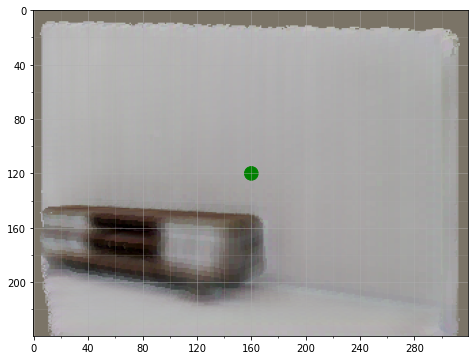

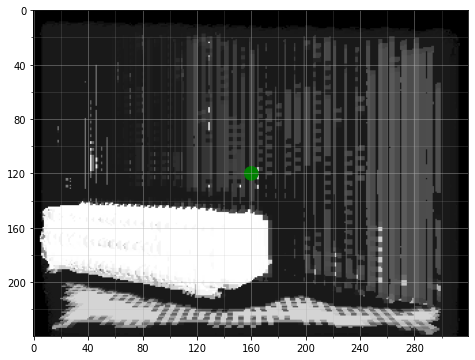

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


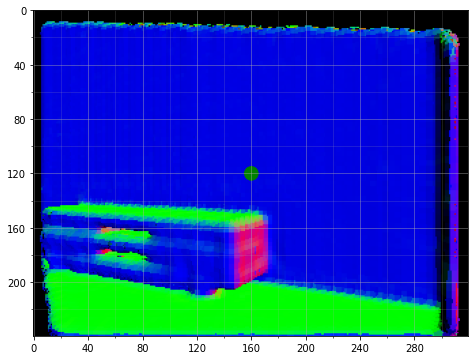

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


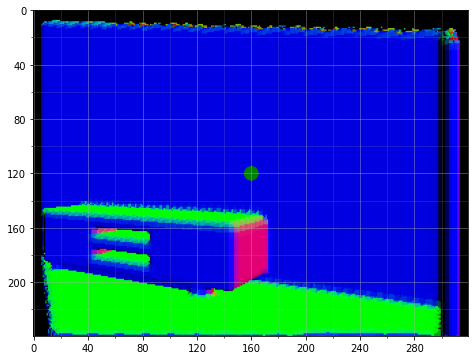

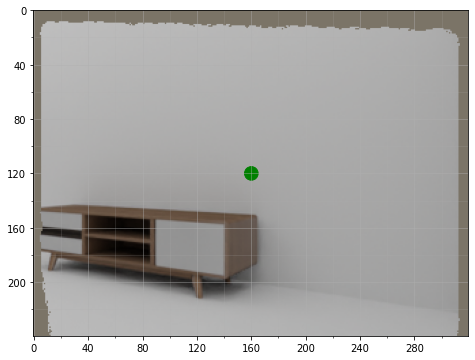

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


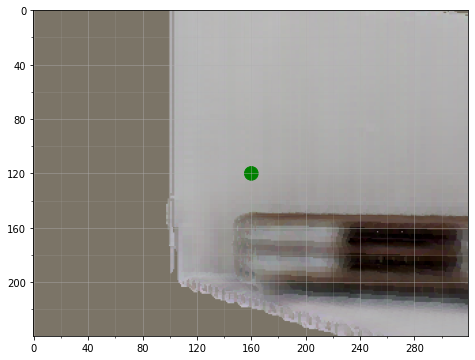

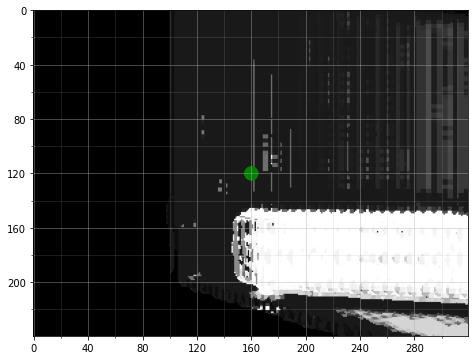

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


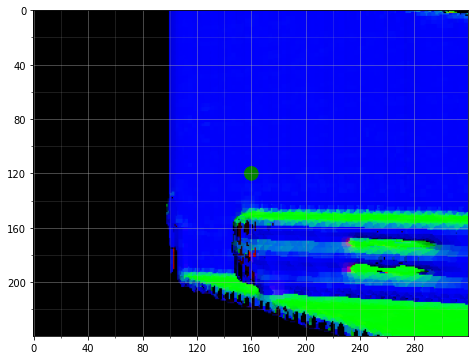

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


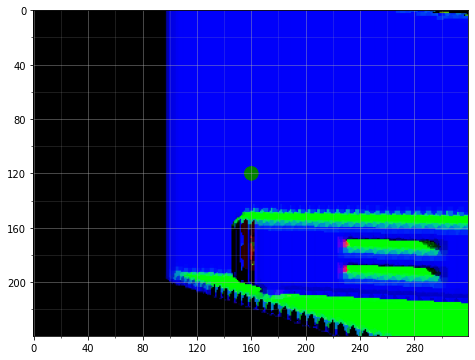

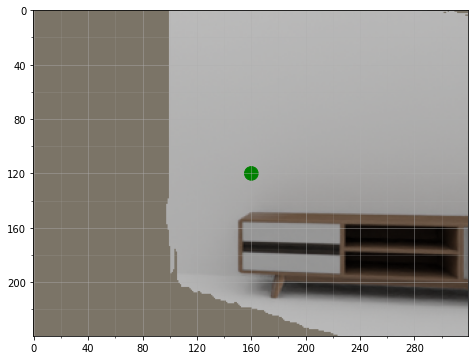

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


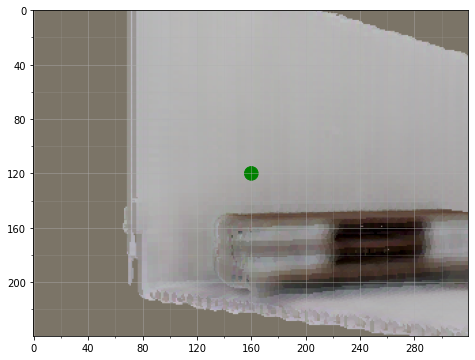

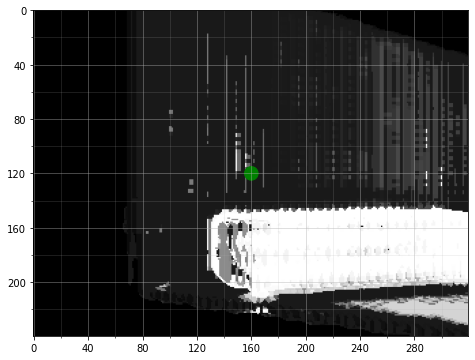

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


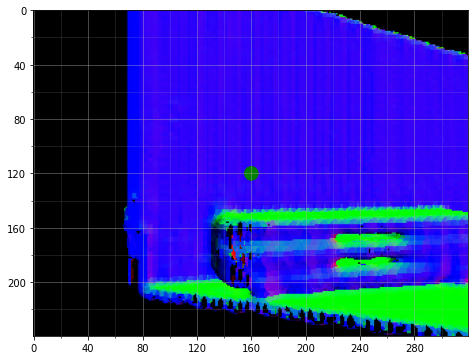

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


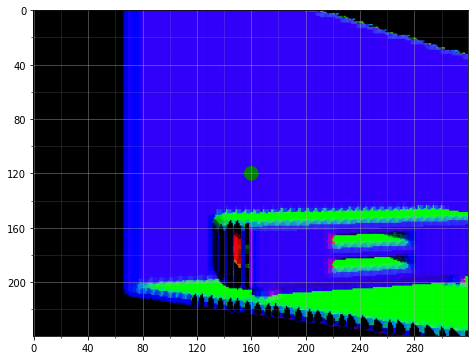

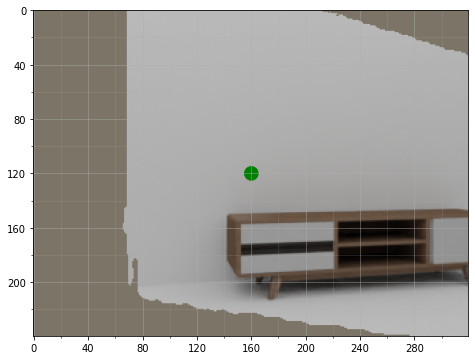

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


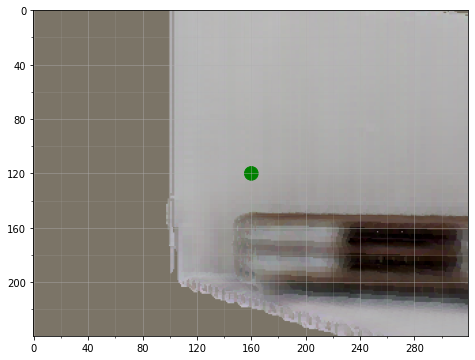

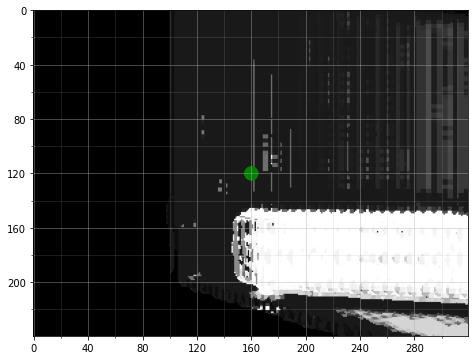

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


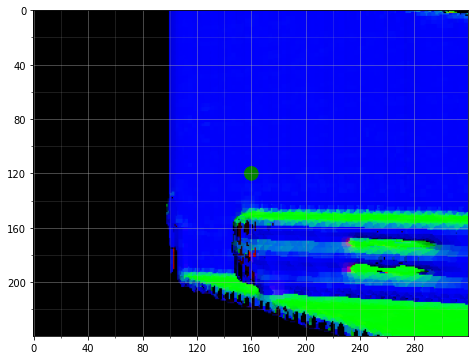

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


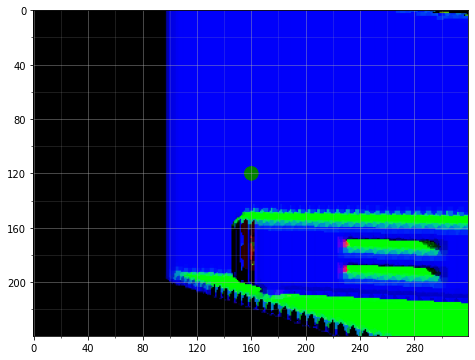

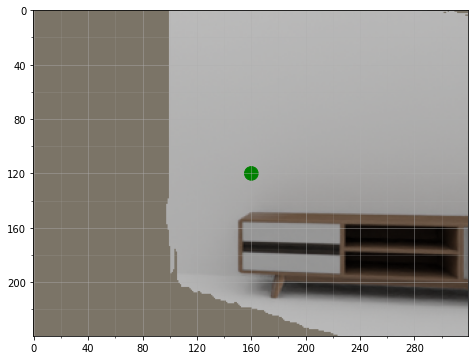

Total loss:  tensor(1.5478, device='cuda:0', grad_fn=<AddBackward0>)
L1 loss:  tensor(0.1039, device='cuda:0', grad_fn=<DivBackward0>)
style loss:  tensor(1.1707, device='cuda:0', grad_fn=<AddBackward0>)
loss_content:  tensor(182.4461, device='cuda:0', grad_fn=<AddBackward0>)
disc_loss:  tensor(1.3877, device='cuda:0', grad_fn=<AddBackward0>)
gen_loss:  tensor(0.7102, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [10]:
from lib.modeling.frustum.rgb_loss import RGBLoss
from plot_image_grid import plot_image

rgb_loss = RGBLoss()
loss = rgb_loss(geometry_sparse_prediction, rgb_sparse_prediction, semantic_sparse_prediction, aux_views, cam_poses.to(device), target_sdf, debug=True)

In [11]:
geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
semantic_sparse_prediction = results['frustum']['semantic3d']
print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)
print("semantic_sparse shape: ", semantic_sparse_prediction.shape)
aux_views = targets[0].get_field("aux_views").unsqueeze(0)
cam_poses = targets[0].get_field("cam_poses").unsqueeze(0)
# cam_poses[:,:,:,:3,-1] /= 0.0301
print("aux_views shape: ", aux_views.shape)
print("cam_poses shape: ", cam_poses.shape)

geometry_sparse shape:  torch.Size([80984, 1])
rgb_sparse shape:  torch.Size([80984, 3])
semantic_sparse shape:  torch.Size([80984, 13])
aux_views shape:  torch.Size([1, 4, 3, 240, 320])
cam_poses shape:  torch.Size([1, 4, 1, 4, 4])


In [12]:
# Get dense
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform
import loss as loss_util

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
geometry = geometry.squeeze()
rgb = rgb.squeeze()
print("input shape: ", images.shape)
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))
print("geometry: {}".format(geometry.shape))
print("geometry values: [{},{}]".format(torch.max(geometry), torch.min(geometry)))

input shape:  torch.Size([1, 3, 240, 320])
rgb: torch.Size([3, 256, 256, 256])
rgb values: [2.455829620361328,-2.7546141147613525]
geometry: torch.Size([256, 256, 256])
geometry values: [3.0,0.0]


In [13]:
from torch.nn import functional as F
volume_size = 128
rgb = rgb.unsqueeze(0)
geometry = geometry.unsqueeze(0).unsqueeze(0)

rgb = (F.interpolate(rgb, size=(volume_size,volume_size,volume_size), mode="trilinear", align_corners=True))
geometry = (F.interpolate(geometry, size=(volume_size,volume_size,volume_size), mode="trilinear", align_corners=True))

print("rgb shape: ", rgb.shape)
print("geometry shape: ", geometry.shape)
print("geometry range: [{},{}]".format(geometry.min(), geometry.max()))
print("aux_views shape: ", aux_views.shape)
print("cam_poses shape: ", cam_poses.shape)

rgb shape:  torch.Size([1, 3, 128, 128, 128])
geometry shape:  torch.Size([1, 1, 128, 128, 128])
geometry range: [0.06334617733955383,3.0]
aux_views shape:  torch.Size([1, 4, 3, 240, 320])
cam_poses shape:  torch.Size([1, 4, 1, 4, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


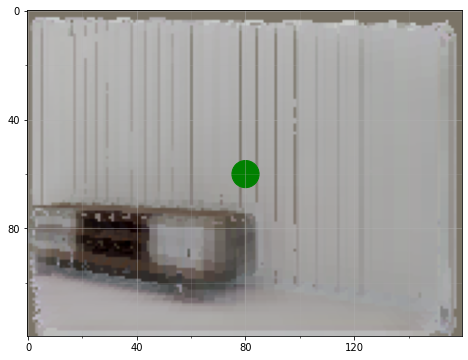

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


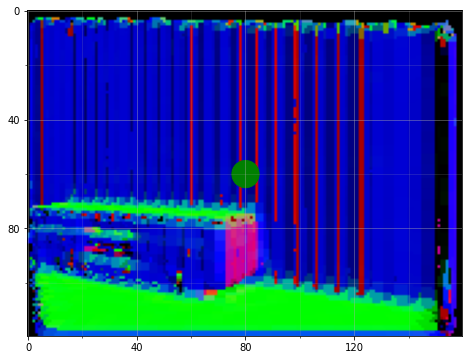

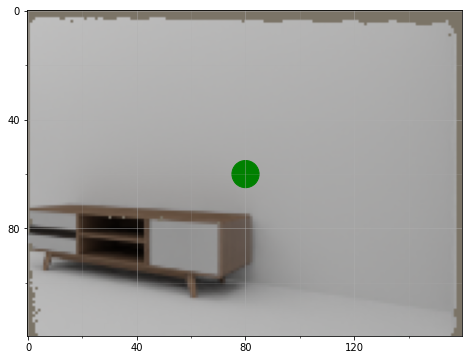

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


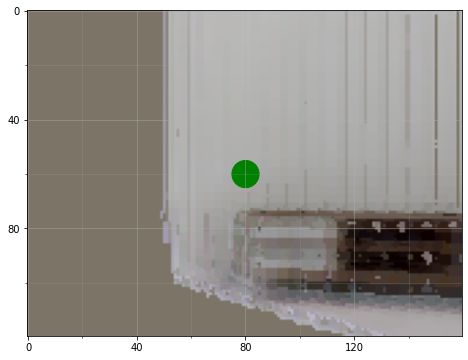

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


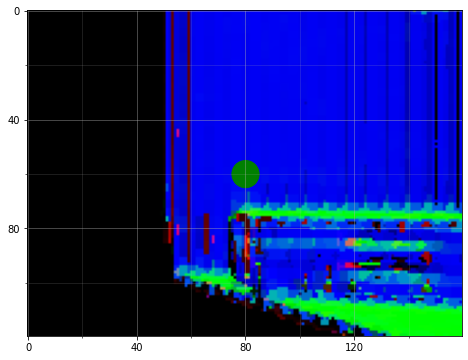

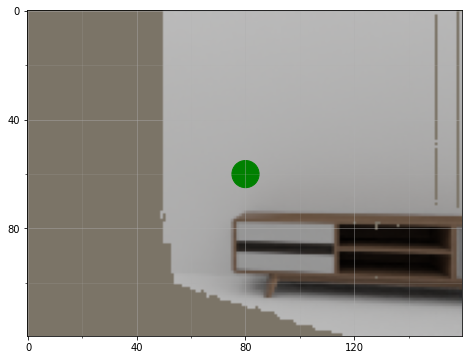

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


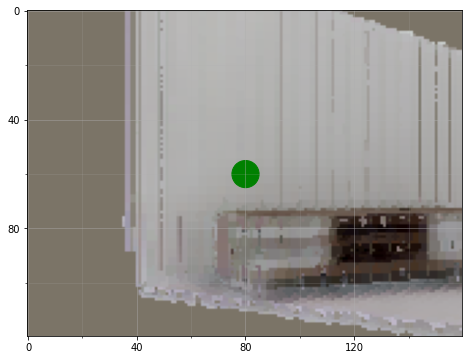

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


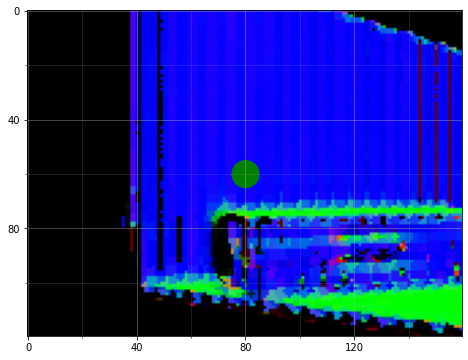

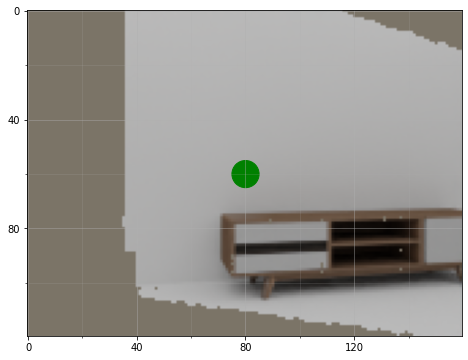

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


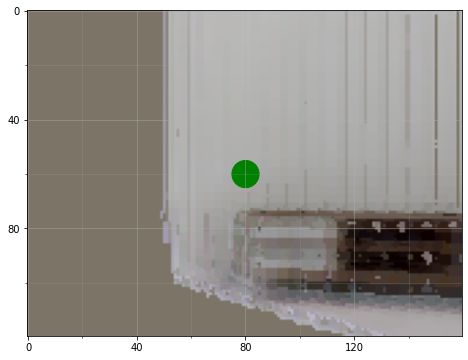

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


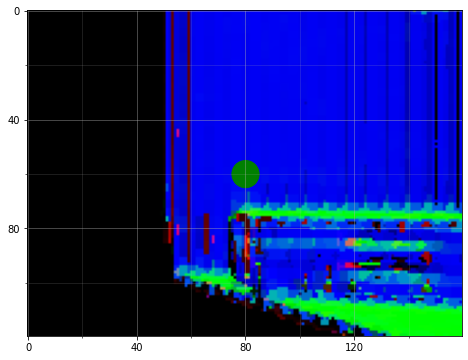

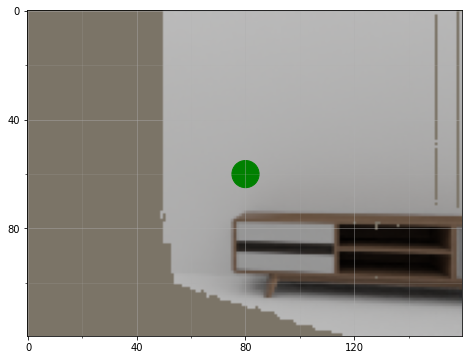

L1 loss:  tensor(0.1652, device='cuda:0', grad_fn=<DivBackward0>)


In [14]:
from lib.modeling.frustum.rgb_loss_proxy import RGBProxyLoss
from plot_image_grid import plot_image

rgb_loss = RGBProxyLoss(volume_size=volume_size)
loss = rgb_loss(rgb.clone(), geometry.clone(), aux_views.clone(), cam_poses.to(device), debug=True)